In [1]:
import cell_logger

In [2]:
%%log
import numpy as np
import keras
import pickle
import scipy.interpolate
import scipy.misc

from scipy.ndimage.filters import gaussian_filter1d

from ultrasoundData import UltrasoundData

udata = UltrasoundData("../ultrasoundHacks/august10OpticalTrack.pickle")
udata.makeData()

udata2 = UltrasoundData("../ultrasoundHacks/august10OpticalTrack2.pickle")
udata2.makeData()

udata3 = UltrasoundData("../ultrasoundHacks/august10OpticalTrack3.pickle")
udata3.makeData()


Using TensorFlow backend.


In [3]:
%%log
traindata = np.concatenate([udata3.data, udata2.data])
testdata = udata.data[50000:]

trainclasses = np.concatenate([udata3.classes, udata2.classes])
testclasses = udata.classes[50000:]


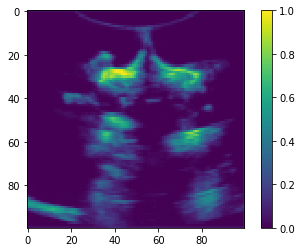

In [4]:
import matplotlib.pyplot as plt
plt.imshow(udata.data[5030, :, :, 0])
plt.colorbar()
plt.show()

In [5]:
%%log
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(100, 100, 1)
                 
                ))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))              
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1, activation='tanh'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [6]:
%%log
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.adam(lr=.001))


loss_curve = model.fit(traindata, 
              trainclasses,
              batch_size=200,
              epochs=5,
              verbose=1,
              validation_data=(testdata, testclasses))



Train on 120000 samples, validate on 10000 samples
Epoch 1/1
120000/120000 [==============================] - 57s - loss: 0.0482 - val_loss: 0.0259


In [7]:
print("unique name of training run for logging:")
save_name = input()
save_dir = "runs/" + save_name
import os
import shutil
os.mkdir(save_dir)
shutil.copyfile("ultrasoundData.py", save_dir + "/ultrasoundData.py")
with open(save_dir + "/notebook_cells_log.py", "w") as file:
    cell_logger.dump_history(file)

model.save(save_dir + "/final_weights")

pickle.dump(loss_curve.history, open("runs/" + save_name + "/loss_"+ str(loss_curve.history["val_loss"][-1]) + ".pickle", "wb"))


unique name for logging:
out


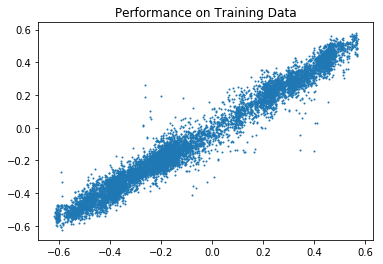

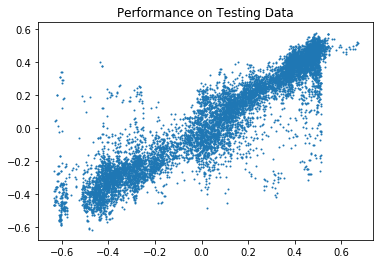

In [7]:
plt.scatter(trainclasses[:10000][:,0] , model.predict(traindata[:10000])[:,0], 1)
plt.title("Performance on Training Data")
#plt.plot([-1, 1], [-1, 1])
plt.show()

plt.scatter(testclasses[:,0] , model.predict(testdata)[:,0], 1)
plt.title("Performance on Testing Data")
#plt.plot([-1, 1], [-1, 1])
plt.show()

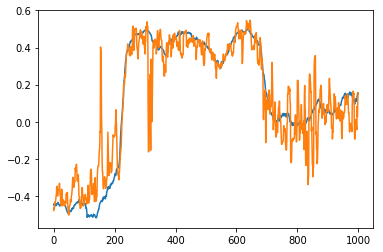

In [8]:


length = 1000
offset = 8000
plt.plot(testclasses[offset:offset + length])
plt.plot(model.predict(testdata[offset:offset + length]))
plt.show()